In [1]:
import os
os.environ["BRASA_DATA_PATH"] = "D:\\brasa"

import sys
sys.path.append('..')

from datetime import datetime

import pandas as pd
import pyarrow as pa
import pyarrow.dataset as ds
import pyarrow.compute as pc

from bizdays import Calendar

from brasa.parsers.b3.futures_settlement_prices import maturity2date
import brasa

In [2]:
ds_curves_di1_std = brasa.get_dataset("b3-curves-di1-standard")

In [4]:
ds_curves_di1_std.schema

refdate: timestamp[us]
symbol: string
maturity_date: timestamp[us]
business_days: int32
adjusted_tax: double

<Axes: xlabel='refdate'>

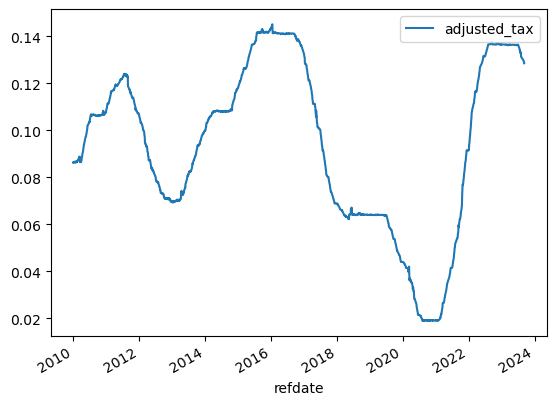

In [9]:
df_1m = ds_curves_di1_std.to_table().filter(pc.field("business_days") == 21).to_pandas()
df_1m.plot(x="refdate", y="adjusted_tax")

<Axes: xlabel='refdate'>

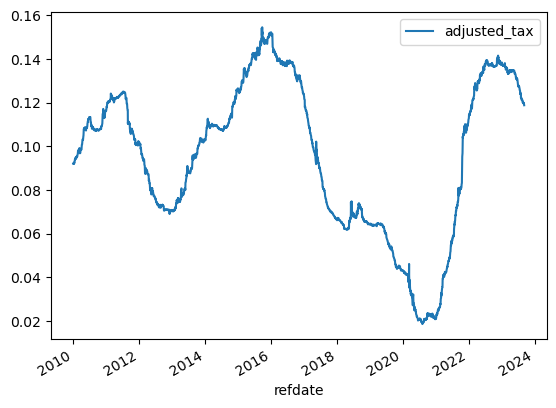

In [10]:
df_6m = ds_curves_di1_std.to_table().filter(pc.field("business_days") == 21 * 6).to_pandas()
df_6m.plot(x="refdate", y="adjusted_tax")

<Axes: xlabel='refdate'>

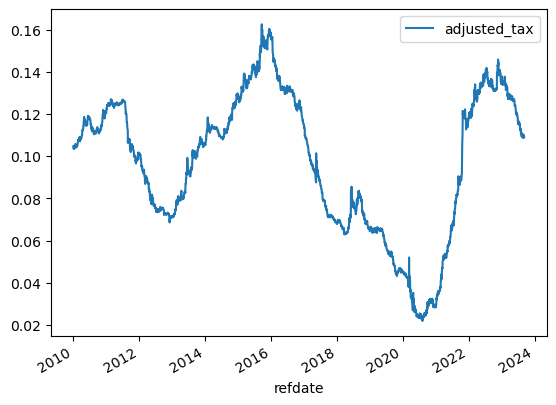

In [ ]:
df_1y = ds_curves_di1_std.to_table().filter(pc.field("business_days") == 252).to_pandas()
df_1y.plot(x="refdate", y="adjusted_tax")

In [62]:
sorted_symbols = [
    "DI1T21",
    "DI1T63",
    "DI1T126",
    "DI1T252",
    "DI1T1260",
    "DI1T2520",
    "DI1T5040"
]

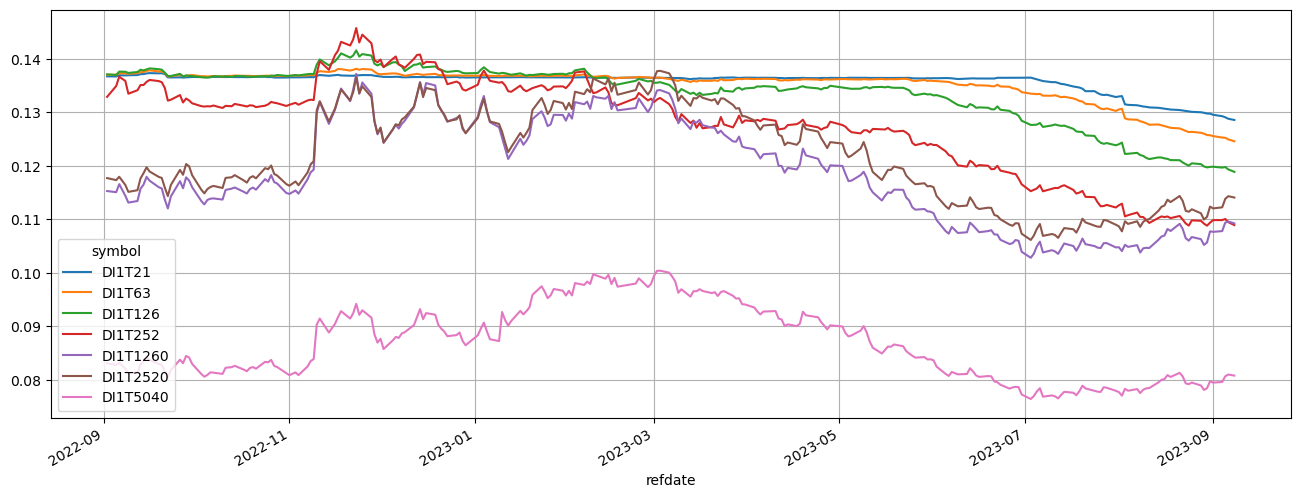

In [67]:
df_curves_di1_std = ds_curves_di1_std.to_table().to_pandas().pivot(columns="symbol", index="refdate", values="adjusted_tax").iloc[-253:,:].loc[:,sorted_symbols]
df_curves_di1_std.plot(figsize=(16, 6)).grid()

<Axes: xlabel='symbol'>

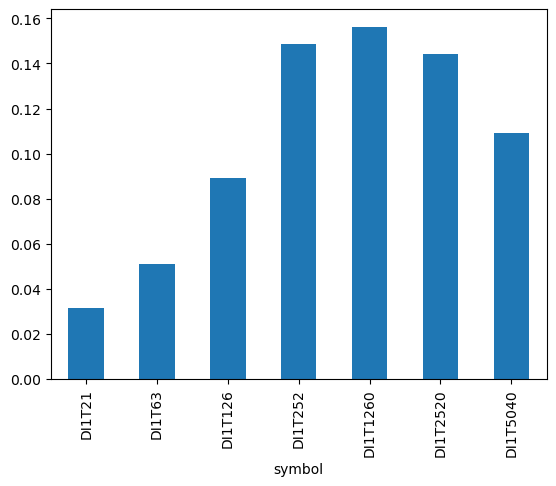

In [68]:
import numpy as np

(df_curves_di1_std.std() * np.sqrt(252)).plot.bar()

In [34]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt

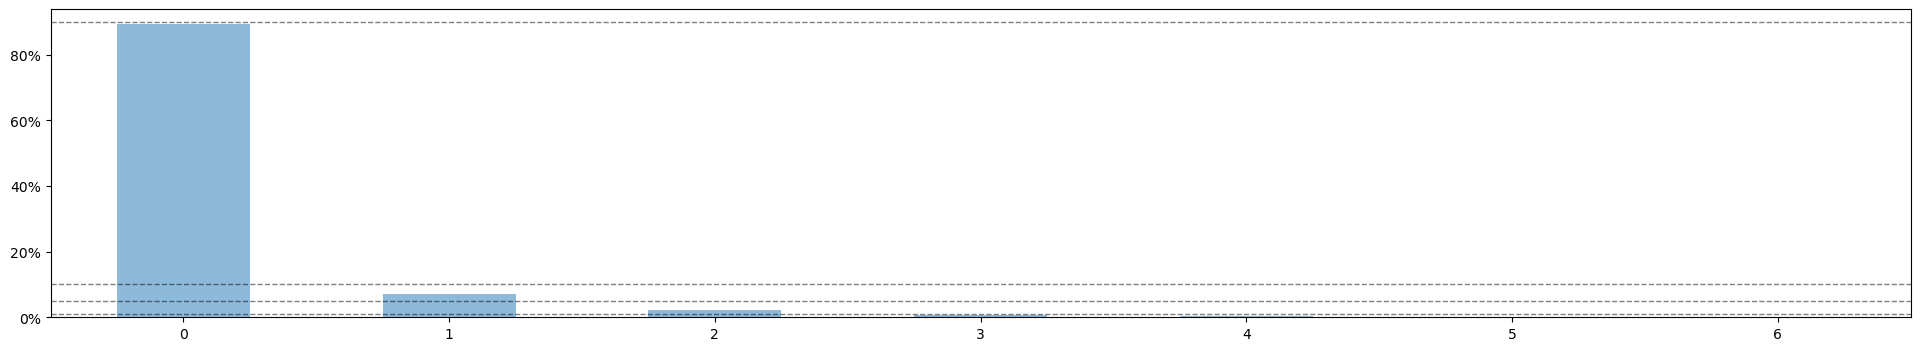

In [57]:
pca = sm.PCA(df_curves_di1_std.diff().dropna(), standardize=False, demean=False)

fig, ax = plt.subplots(figsize=(24, 4))
(100 * pca.eigenvals / pca.eigenvals.sum()).head(50).plot.bar(rot=0, ax=ax, alpha=0.5).yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
for i in [1, 5, 10, 90]:
    ax.axhline(y=i, color='black', linestyle='--', alpha=0.5, linewidth=1)
plt.show()

Aqui observamos que os vértices de 5 anos (1260 DU) e 10 anos (2520 DU) têm as maiores contribuições à variância.

Uma análise interessante é observar em janela móvel quais vértices têm maiores contribuições.
Pode haver uma transição da relevância ao longo do tempo e isso pode estar relacionado a ciclos de mercado.

Outra abordagem é a criação de um dataset com os vencimentos ordenados: primeiro, segundo, terceiro ... até o décimo,
por exemplo.
O PCA seria aplicado a essa base e com isso teríamos a relevância dos contratos, ao invés dos vértices padronizados.

<Axes: xlabel='symbol'>

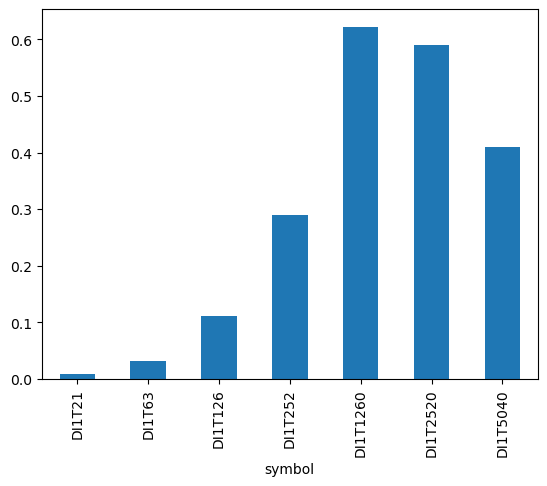

In [59]:
pca.loadings.loc[sorted_symbols, "comp_0"].plot.bar()

<Axes: xlabel='symbol'>

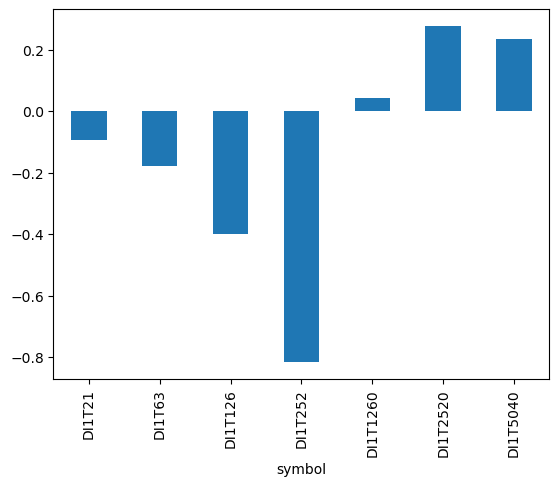

In [60]:
pca.loadings.loc[sorted_symbols, "comp_1"].plot.bar()

<Axes: xlabel='symbol'>

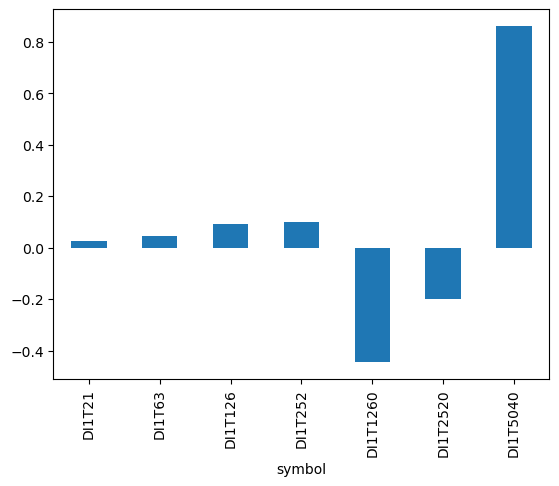

In [61]:
pca.loadings.loc[sorted_symbols, "comp_2"].plot.bar()